In [89]:
import torch
from torch.distributions import MultivariateNormal
from torch import tensor
import matplotlib.pyplot as plt
import math
from functools import partial
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [36]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140)

In [37]:
n_clusters = 6
n_samples = 250

In [38]:
centroids = torch.rand(n_clusters,2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [39]:
MultivariateNormal?

Init signature:
MultivariateNormal(
    loc,
    covariance_matrix=None,
    precision_matrix=None,
    scale_tril=None,
    validate_args=None,
)
Docstring:     
Creates a multivariate normal (also called Gaussian) distribution
parameterized by a mean vector and a covariance matrix.

The multivariate normal distribution can be parameterized either
in terms of a positive definite covariance matrix :math:`\mathbf{\Sigma}`
or a positive definite precision matrix :math:`\mathbf{\Sigma}^{-1}`
or a lower-triangular matrix :math:`\mathbf{L}` with positive-valued
diagonal entries, such that
:math:`\mathbf{\Sigma} = \mathbf{L}\mathbf{L}^\top`. This triangular matrix
can be obtained via e.g. Cholesky decomposition of the covariance.

Example:

    >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_LAPACK)
    >>> # xdoctest: +IGNORE_WANT("non-determenistic")
    >>> m = MultivariateNormal(torch.zeros(2), torch.eye(2))
    >>> m.sample()  # normally distributed with mean=`[0,0]` and covariance_matrix=`

In [40]:
def data_centroids(c):
    return MultivariateNormal(c, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [41]:
slices = [data_centroids(o) for o in centroids]

In [42]:
data = torch.cat(slices)

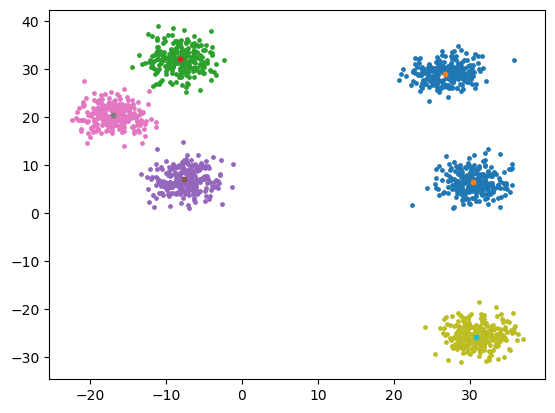

In [43]:
for i, centroid in enumerate(centroids):
    samples = data[i*n_samples:(i+1)*n_samples]
    plt.scatter(samples[:,0], samples[:,1], s=6)
    plt.scatter(*centroid, s=10)

In [44]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid,  markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid,  markersize=5, marker="x", color='m', mew=2)

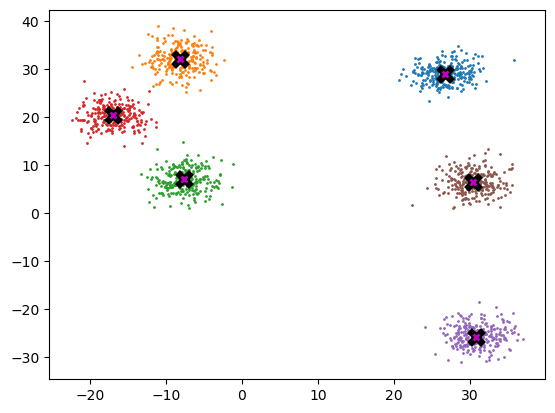

In [45]:
plot_data(centroids,data,n_samples)

In [46]:
def gaussian(mean, theta,x): 
    return 1/((2*theta**2*math.pi)**0.5) * math.exp(-(((x-mean)**2)/(2*theta**2)))

In [47]:
test = partial(gaussian,0,3)

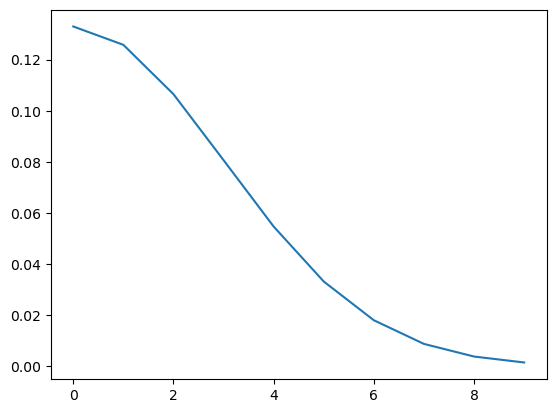

In [48]:
plt.plot([test(o) for o in range(0,10)])

In [49]:
def gaussian2(d, bw): 
    return 1/((2*bw**2*math.pi)**0.5) * math.exp(-(((d)**2)/(2*bw**2)))

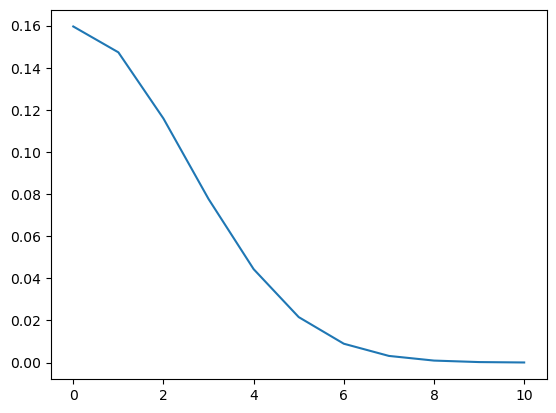

In [50]:
test2 = partial(gaussian2,bw=2.5)
plt.plot([test2(o) for o in range(0,11)])

In [51]:
def gaussian3(d, bw): 
    return 1/((2*bw**2*math.pi)**0.5) * torch.exp(-(((d)**2)/(2*bw**2)))

In [52]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x,f(x))

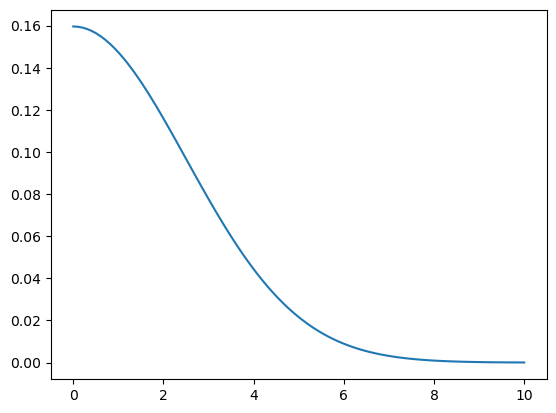

In [53]:
test3 = partial(gaussian3,bw=2.5)
plot_func(test3)

In [54]:
def tri(d,i):
    return ((i-d)/i).clamp_min(0)

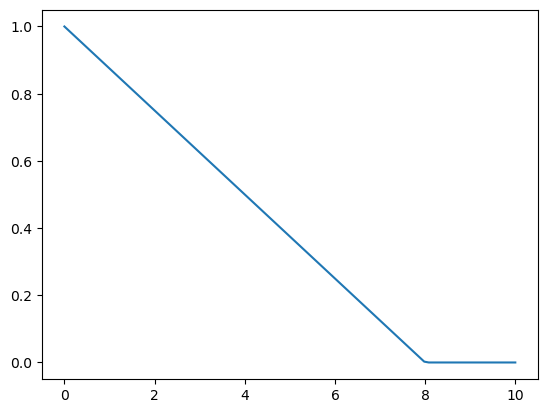

In [55]:
tri_test = partial(tri,i=8)
plot_func(tri_test)

The algorithm is as follows:

-For each data point x in the sample X, find the distance between that point x and every other point in X

-Create weights for each point in X by using the Gaussian kernel of that point's distance to x

-This weighting approach penalizes points further away from x

-The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian

-Update x as the weighted average of all other points in X, weighted based on the previous step

-This will iteratively push points that are close together even closer until they are next to each other.

In [56]:
X = data.clone()

In [57]:
X

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        ...,
        [30.772,  9.323],
        [29.354,  3.960],
        [31.168,  5.309]])

In [58]:
x = X[0]
x

tensor([26.204, 26.349])

In [59]:
# rewrite using torch.einsum

d = torch.sqrt(((x[None]-X)**2).sum(dim=1)) #d=√((x_2-x_1)²+(y_2-y_1)²)
d

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [60]:
dif = ((x[None]-X)**2)
dif.shape


torch.Size([1500, 2])

In [61]:
d_einsum = torch.einsum('ij -> i',dif).sqrt()
d_einsum

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [62]:
dif = (x[None]-X)
d_einsum = torch.einsum('ij, ij -> i',dif,dif).sqrt()
d_einsum

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [63]:
w = tri_test(d)
w

tensor([1.000, 0.513, 0.396,  ..., 0.000, 0.000, 0.000])

In [64]:
torch.sum(X*w[:,None],dim=0)/torch.sum(w)

tensor([26.536, 28.502])

In [65]:
def mean_shift():
    X = data.clone()
    for i in range(5):
        for j in range(len(X)):
            x = X[j]
            d = torch.sqrt(((x[None]-X)**2).sum(dim=1))
            w = tri_test(d)
            X[j] = torch.sum(X*w[:,None],dim=0)/torch.sum(w)
    return X

In [66]:
X_mean_shift = mean_shift()

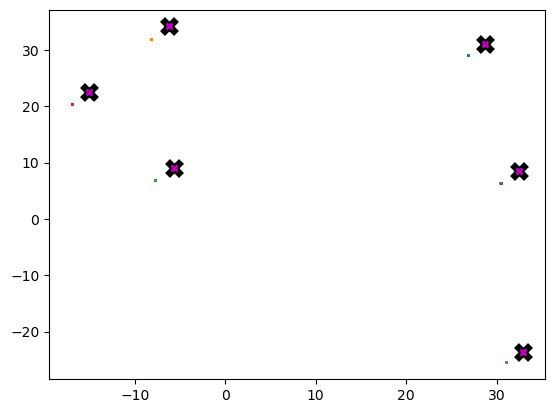

In [67]:
plot_data(centroids+2,X_mean_shift,n_samples)

In [68]:
X = data.clone()
x = X[0:5]
x[:,None].shape, X[None].shape


(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]))

In [69]:
d = torch.sqrt(((x[:,None]-X[None])**2).sum(dim=2))
d


tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [70]:
w = tri_test(d)
w[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [71]:
torch.sum(X[None]*w[...,None],dim=1)/torch.sum(w[...,None],dim=1)

tensor([[26.536, 28.502],
        [26.460, 29.361],
        [27.857, 29.126],
        [26.443, 29.322],
        [28.172, 29.483]])

In [72]:
def mean_shift_batch(b):
    X = data.clone()
    for i in range(5):
        for j in range(0,len(X),b):
            x = X[j:(j+b)]
            d = torch.sqrt(((x[:,None]-X[None])**2).sum(dim=2))
            w = tri_test(d)
            X[j:(j+b)] = torch.sum(X[None]*w[...,None],dim=1)/torch.sum(w[...,None],dim=1)
    return X

In [73]:
%time X_mean_shift_batch = mean_shift_batch(500)

CPU times: user 2.27 s, sys: 260 ms, total: 2.53 s
Wall time: 280 ms


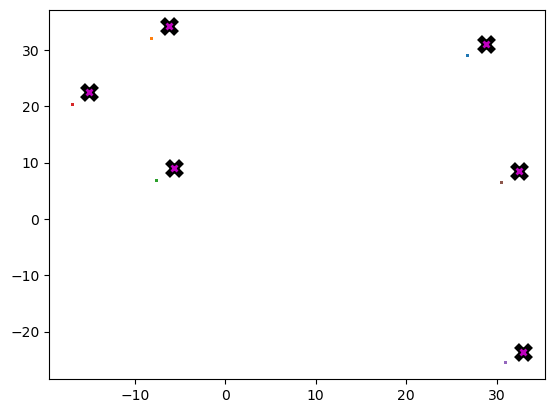

In [74]:
plot_data(centroids+2,X_mean_shift_batch,n_samples)

In [75]:
def mean_shift_batch_cuda(b):
    X = data.clone()
    X.cuda()
    for i in range(5):
        for j in range(0,len(X),b):
            x = X[j:(j+b)]
            d = torch.sqrt(((x[:,None]-X[None])**2).sum(dim=2))
            w = tri_test(d)
            X[j:(j+b)] = torch.sum(X[None]*w[...,None],dim=1)/torch.sum(w[...,None],dim=1)
    return X

In [76]:
torch.cuda.is_available()

True

In [77]:
%time X_mean_shift_batch_cuda = mean_shift_batch_cuda(500).cpu()

CPU times: user 3.2 s, sys: 642 ms, total: 3.84 s
Wall time: 2.38 s


In [82]:
def mean_shift_one():
    for j in range(len(X)):
        x = X[j]
        d = torch.sqrt(((x[None]-X)**2).sum(dim=1))
        w = tri_test(d)
        X[j] = torch.sum(X*w[:,None],dim=0)/torch.sum(w)
    return X

In [107]:
def do_one(d):
    if d: mean_shift_one()
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [108]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()

In [109]:
HTML(ani.to_jshtml())

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()
     

def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X
     